# Aligning MRS voxels with the anatomy

Several steps in the analysis and interpertation of the MRS data require knowledge of the anatomical location of the volume from which MRS data was acquired. In particular, we would like to know how much of the volume contains gray matter, relative to other tissue components, such as white matter, CSF, etc. In order to infer this, we need to acquire a T1-weighted MRI scan in the same session, and (assuming the subject hasn't moved too much), use the segmentation of the T1w image into different tissue types (e.g. using [Freesurfer](http://surfer.nmr.mgh.harvard.edu)). 

However, in order to do that, we first need to align the MRS voxel with the T1w data, so that we can extract these quantities. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import os.path as op
import nibabel as nib
import MRS.data as mrd

import IPython.html.widgets as wdg
import IPython.display as display

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
mrs_nifti = nib.load(op.join(mrd.data_folder, '12_1_PROBE_MEGA_L_Occ.nii.gz'))
t1_nifti = nib.load(op.join(mrd.data_folder, '5062_2_1.nii.gz'))

In order to be able to align the files with regard to each other, they need to both encode an affine transformation relative to the scanner space. For a very thorough introduction to these transformations and their utility, see [this tutorial](http://nipy.bic.berkeley.edu/nightly/nibabel/doc/coordinate_systems.html) 

In [3]:
mrs_aff = mrs_nifti.get_affine()

In [4]:
t1_aff = t1_nifti.get_affine()

In [5]:
print("The affine transform for the MRS data is:")
print(mrs_aff) 
print("The affine transform for the T1 data is:")
print(t1_aff)

The affine transform for the MRS data is:
[[ 25.           0.           0.         -26.42120361]
 [  0.          25.           0.         -50.99639511]
 [  0.           0.          25.          23.03520012]
 [  0.           0.           0.           1.        ]]
The affine transform for the T1 data is:
[[  -0.89840001    0.            0.          115.24199677]
 [   0.           -0.89840001    0.          119.76899719]
 [   0.            0.            0.89999998  -59.58800125]
 [   0.            0.            0.            1.        ]]


If you read the aformentioned [tutorial](http://nipy.bic.berkeley.edu/nightly/nibabel/doc/coordinate_systems.html), this will make sense. The diagonal of the top ledt 3 x 3 matrix encodes the resolution of the voxels used in each of the acquisitions (in mm). The MRS data has a single 2.5 x 2.5 x 2.5 cm$^2$ isotropic voxel, and the T1 has (approximately) 0.9 x 0.9 x 0.9 mm$^2$ isotropic voxels. They were both acquired without any rotation relative to the scanner coordinate system, which is why the off-diagonal terms of the top left 3 x 3 matrix is all zeros. The 4th column of each of these matrices encodes the xyz shift (again, in mm) relative to the scanner isocenter.  

Composing these two transformations together tells us how to align the two volumes relative to each other. In particular, we might ask where in the t1 coordinate system the center of the MRS voxel is. Since we are multiplying 

In [6]:
composed_affine = np.dot(np.linalg.pinv(t1_aff), mrs_aff)

This allows us to compute the location of the center of the MRS voxel in the T1 volume coordinates, and the locations of the corners of the voxel:

In [7]:
mrs_center = [0,0,0,1]

t1_center = np.round(np.dot(composed_affine, mrs_center)).astype(int)

mrs_corners = [[-0.5, -0.5, -0.5, 1],
               [-0.5, -0.5,  0.5, 1],
               [-0.5,  0.5, -0.5, 1],
               [-0.5,  0.5,  0.5, 1],
               [ 0.5, -0.5, -0.5, 1],
               [ 0.5, -0.5,  0.5, 1],
               [ 0.5,  0.5, -0.5, 1],
               [ 0.5,  0.5,  0.5, 1]] 

t1_corners = [np.round(np.dot(composed_affine, c)).astype(int) for c in mrs_corners]

In [8]:
t1_corners

[array([172, 204,  78,   1]),
 array([172, 204, 106,   1]),
 array([172, 176,  78,   1]),
 array([172, 176, 106,   1]),
 array([144, 204,  78,   1]),
 array([144, 204, 106,   1]),
 array([144, 176,  78,   1]),
 array([144, 176, 106,   1])]

Using this information, we can manually create a volume that only contains the T1-weighted data in the MRS ROI:

In [9]:
t1_data = t1_nifti.get_data().squeeze()

In [10]:
mrs_roi = np.ones_like(t1_data) * np.nan
mrs_roi[144:172, 176:204, 78:106] = t1_data[144:172, 176:204, 78:106]

To view this, we will create a rather rough orthographic viewer of the T1 data, using IPython's interactive widget system. We add the data int the MRS ROI using a different color map, so that we can see where it is in the context of the anatomy

In [11]:
def show_voxel(x=t1_center[0], y=t1_center[1], z=t1_center[2]):
    fig = plt.figure()
    ax = fig.add_subplot(221)
    ax.axis('off')
    ax.imshow(np.rot90(t1_data[:, :, z]), matplotlib.cm.bone)
    ax.imshow(np.rot90(mrs_roi[:, :, z]), matplotlib.cm.jet)
    ax.plot([x, x], [0, t1_data.shape[0]], color='w')
    ax.plot([0, t1_data.shape[1]], [y, y], color='w')
    ax.set_ylim([0, t1_data.shape[0]])
    ax.set_xlim([0, t1_data.shape[1]])
    ax = fig.add_subplot(222)
    ax.axis('off')
    ax.imshow(np.rot90(t1_data[:, -y, :]), matplotlib.cm.bone)
    ax.imshow(np.rot90(mrs_roi[:, -y, :]), matplotlib.cm.jet)
    ax.plot([x, x], [0, t1_data.shape[1]], color='w')
    ax.plot([0, t1_data.shape[1]], [z, z], color='w')
    ax.set_xlim([0, t1_data.shape[0]])
    ax.set_ylim([t1_data.shape[2], 0])
    ax = fig.add_subplot(223)
    ax.axis('off')
    ax.imshow(np.rot90(t1_data[x, :, :]), matplotlib.cm.bone)
    ax.imshow(np.rot90(mrs_roi[x, :, :]), matplotlib.cm.jet)
    ax.plot([t1_data.shape[1]-y, t1_data.shape[1]-y], [0, t1_data.shape[1]], color='w')
    ax.plot([0, t1_data.shape[1]], [z, z], color='w')
    ax.set_xlim([0, t1_data.shape[1]])
    ax.set_ylim([t1_data.shape[2], 0])
    fig.set_size_inches(10, 10)
    return fig

In [12]:
def voxel_viewer(t1_data, mrs_roi):
    pb_widget = wdg.interactive(show_voxel,
                            t1_data = wdg.fixed(t1_data),
                            mrs_roi = wdg.fixed(mrs_roi),
                            x=wdg.IntSliderWidget(min=0, max=t1_data.shape[0]-1, value=155),
                            y=wdg.IntSliderWidget(min=0, max=t1_data.shape[1]-1, value=65),
                            z=wdg.IntSliderWidget(min=0, max=t1_data.shape[2]-1, value=92)
                            )
    display.display(pb_widget)

/Users/arokem/anaconda3/envs/py2/lib/python2.7/site-packages/IPython/utils/traitlets.py:438: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


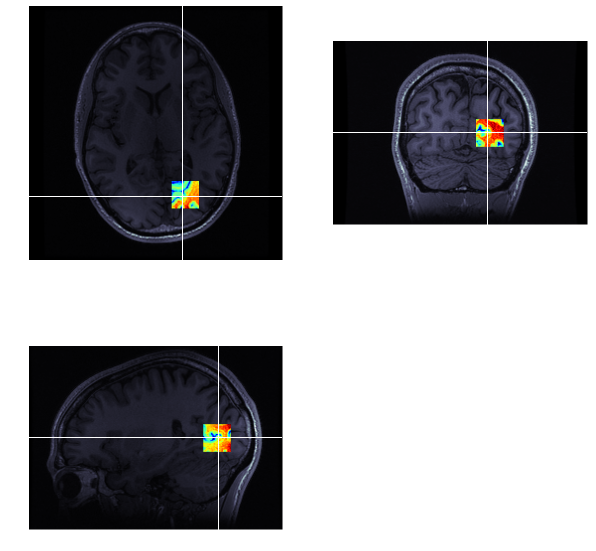

In [13]:
voxel_viewer(t1_data, mrs_roi)

Note that SMAL contains a module that will use the T1 information to extract the voxel statistics, based on a Freesurfer segmentation. This is the `MRS.freesurfer` module. See the module documentation for more details

# Caveat 

Finally, an important caveat: the MRS voxel is a large voxel and its edges are not as sharp as you might want them to be. Many scan sequences will apply suppression bands of out-of-volume information, but even so, there is a fall-off of information around the edges of the nominal MRS voxel. There, you might want to consider your alignment and segmentation to be rough estimates.